**1.  Install and Import Necessary Packages and Libraries**

In [1]:
# Check the README.md file for the instructions on how to install the 
# required packages (and associated versions) to run this script.

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from scipy.spatial import cKDTree
from sklearn.cluster import MiniBatchKMeans
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

**2. Load all Input Landscape Data & Create Dataframe**

To see how each input dataset was derived, kindly see the GEE_data_acq.ipnyb notebook which is located at: _f'../notebooks/GEE_Dataset._

In [3]:
# Load classified images
landcover_path = 'all_input_dataset/Nigeria_Landcover_2021.tif'
elevation_path = 'all_input_dataset/Classified_Altitude_Nigeria.tif'
climate_path = 'all_input_dataset/Nig_climate.tif'
geology_path = 'all_input_dataset/Nig_geology.tif'


# Function to convert raster to dataframe
def raster_to_dataframe(raster_path, mask_values=None):
    with rasterio.open(raster_path) as src:
        raster = src.read(1)
        if mask_values is not None:
            for mask_value in mask_values:
                raster = np.ma.masked_equal(raster, mask_value)  # Mask NoData values

        if hasattr(raster, 'mask') and np.all(raster.mask):
            raise ValueError(f"All values are masked in the raster: {raster_path}")

        transform = src.transform
        if hasattr(raster, 'mask') and raster.mask.ndim != 2:
            raise ValueError(f"Unexpected mask dimensions in the raster: {raster_path}")

        rows, cols = np.where(~raster.mask) if hasattr(raster, 'mask') else np.where(np.isfinite(raster))
        if len(rows) == 0 or len(cols) == 0:
            raise ValueError(f"No valid data found in the raster: {raster_path}")

        x_coords, y_coords = rasterio.transform.xy(transform, rows, cols)
        values = raster[rows, cols]
        df = pd.DataFrame({'X': x_coords, 'Y': y_coords, 'Value': values})
    return df


# Function to append raster data to an existing dataframe with a tolerance
def append_raster_data(df, raster_path, mask_values=None, column_name='Value', tolerance=500):
    new_df = raster_to_dataframe(raster_path, mask_values)

    # Use cKDTree for efficient spatial joins
    tree = cKDTree(new_df[['X', 'Y']].values)
    distances, indices = tree.query(df[['X', 'Y']].values, distance_upper_bound=tolerance)

    # Append new data to the existing dataframe
    df[column_name] = np.nan
    valid = distances != np.inf
    df.loc[valid, column_name] = new_df['Value'].values[indices[valid]]

    return df


# Load elevation data
elevation_df = raster_to_dataframe(elevation_path, mask_values=[0, -32768])
elevation_df.rename(columns={'Value': 'Elevation'}, inplace=True)

# Load and append climate data
elevation_df = append_raster_data(elevation_df, climate_path, mask_values=[0], column_name='Climate')

# Load and append landcover data
elevation_df = append_raster_data(elevation_df, landcover_path, mask_values=[0], column_name='Landcover')

# Load and append geology data
elevation_df = append_raster_data(elevation_df, geology_path, mask_values=[0], column_name='Geology')

# Remove rows with any null values
elevation_df.dropna(inplace=True)

# Convert all values to integers, except for LST which remains as float
elevation_df = elevation_df.astype({'X': int, 'Y': int, 'Elevation': int, 'Climate': int, 'Landcover': int, 'Geology': int})

# Save the final dataframe to a CSV file
landscape_df = elevation_df
landscape_df.to_csv('all_output/landscape_df_cluster_det.csv', index=False) #Landscape dataframe for cluster determination

# Display a message indicating success
print("Data successfully saved")

print(landscape_df.head(5))

Data successfully saved
        X        Y  Elevation  Climate  Landcover  Geology
0  615500  1561500          2        4         40        4
2  611500  1560500          2        4         30        4
3  612500  1560500          2        4         30        4
4  613500  1560500          2        4         30        4
5  614500  1560500          2        4         30        4


**3.  Determination of Optimal Number of Clusters**

Here, we determine the Optimal Number of Clusters (_k_) by using *Gap Statistics* and further confirm our result by computing *Silhouette Coefficient*. The _k_-value is important/needed to run the KMeans analysis.

Our protocol tends to use natural factors for clustering and then apply the cultural element (i.e. land cover) to further describe and delineate the landscape types found. Thus, all physical landscape elements are considered on one hand, then land cover is eliminated and both possibilities analysed and plotted. On both the Gap and Silhouette plots, where the curve begins to decay or flatten, indicates the potential number of clusters (_k_) that suits either options considered - and yes, some trade-offs were made!

**3.1 Compute Gap Statistics - All Landscape Element/Without Landcover**

**3.1.1 First Run - 500 Clusters**

*NOTE: _The block for 500 clusters can run for about **24hrs**, depending on processor speed. To download the result of this phase, just as other results, see the project repos - Git/Zenodo/DANS._*

Gap statistics for all features calculated using DASK.
Gap statistics without landcover calculated using DASK.


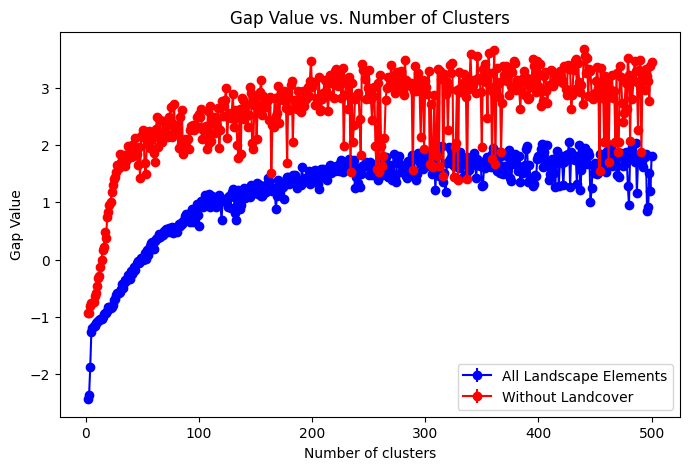

2024-08-11 06:35:16,203 - distributed.nanny - WARNING - Worker process still alive after 3.199991149902344 seconds, killing
2024-08-11 06:35:16,278 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2024-08-11 06:35:16,649 - distributed.nanny - WARNING - Worker process still alive after 3.1999987792968754 seconds, killing
2024-08-11 06:35:16,684 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2024-08-11 06:35:16,685 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2024-08-11 06:35:16,687 - distributed.nanny - WARNING - Worker process still alive after 3.1999986267089846 seconds, killing
2024-08-11 06:35:16,766 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing


In [8]:
# GAP STATISTICS - Assumed number of clusters = 500

# Set up DASK client to parallelize the process...
cluster = LocalCluster()
client = Client(cluster)

# Function to compute gap statistics using DASK
def compute_gap_statistics(data, max_k, sample_size=94132, B=10): #10% of total number of pixels
    def compute_dispersion(data, k):
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        clusters = kmeans.predict(data)
        cluster_centers = kmeans.cluster_centers_
        dispersion = sum(np.linalg.norm(data - cluster_centers[clusters], axis=1)) / data.shape[0]
        return dispersion
    
    def compute_reference_dispersion(data, k):
        dispersions = []
        for _ in range(B):
            reference_data = np.random.uniform(size=data.shape)
            dispersion = compute_dispersion(reference_data, k)
            dispersions.append(dispersion)
        return np.mean(dispersions), np.std(dispersions)
    
    K = range(2, max_k + 1)
    
    # Sample the data
    if len(data) > sample_size:
        data_sample = data.sample(n=sample_size, random_state=42)
    else:
        data_sample = data
    
    # Convert to DASK DataFrame
    ddf_sample = dd.from_pandas(data_sample, npartitions=4)
    
    gap_values = []
    std_devs = []
    
    for k in K:
        dispersion = compute_dispersion(ddf_sample.compute(), k)
        ref_dispersion, std_dev = compute_reference_dispersion(ddf_sample.compute(), k)
        gap_values.append(np.log(ref_dispersion) - np.log(dispersion))
        std_devs.append(std_dev)
    
    return gap_values, std_devs, K

# Perform gap statistic computation with all features using DASK
gap_values_all, std_devs_all, K_all = compute_gap_statistics(
    landscape_df[['Climate', 'Geology', 'Elevation', 'Landcover']], max_k=500)
print(f'Gap statistics for all features calculated using DASK.')

# Perform gap statistic computation without the landcover feature using DASK
gap_values_wt_lc, std_devs_wt_lc, K_wt_lc = compute_gap_statistics(
    landscape_df[['Climate', 'Geology', 'Elevation']], max_k=500)
print(f'Gap statistics without landcover calculated using DASK.')

# Save the gap statistics and the number of clusters to a CSV file
results_df_all = pd.DataFrame({'Number of Clusters': K_all, 'Gap Value (all features)': gap_values_all, 'Std Dev (all features)': std_devs_all})
results_df_wt_lc = pd.DataFrame({'Number of Clusters': K_wt_lc, 'Gap Value (without landcover)': gap_values_wt_lc, 'Std Dev (without landcover)': std_devs_wt_lc})
gap_df = pd.merge(results_df_all, results_df_wt_lc, on='Number of Clusters')
gap_df.to_csv('all_output/gap_statistics500_comparison.csv', index=False)

# Plot the gap statistics for both runs
plt.figure(figsize=(8, 5))
plt.errorbar(K_all, gap_values_all, yerr=std_devs_all, fmt='bo-', label='All Landscape Elements')
plt.errorbar(K_wt_lc, gap_values_wt_lc, yerr=std_devs_wt_lc, fmt='ro-', label='Without Landcover')
plt.xlabel('Number of clusters')
plt.ylabel('Gap Value')
plt.title('Gap Value vs. Number of Clusters')
plt.legend()

# Save the plot as both .svg and .png files
plt.savefig('all_output/gap_statistics500_comparison_plot.svg')
plt.savefig('all_output/gap_statistics500_comparison_plot.png')

plt.show()

# Close the DASK client and cluster
client.close()
cluster.close()


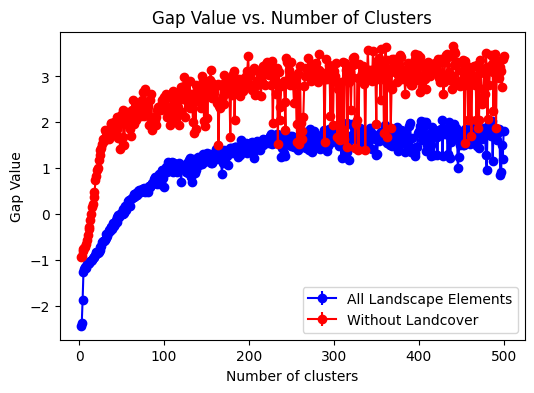

In [9]:
# Re-Plot - Smaller Size
plt.figure(figsize=(6, 4))
plt.errorbar(K_all, gap_values_all, yerr=std_devs_all, fmt='bo-', label='All Landscape Elements')
plt.errorbar(K_wt_lc, gap_values_wt_lc, yerr=std_devs_wt_lc, fmt='ro-', label='Without Landcover')
plt.xlabel('Number of clusters')
plt.ylabel('Gap Value')
plt.title('Gap Value vs. Number of Clusters')
plt.legend()

# Save the plot as both .svg and .png files
plt.savefig('all_output/gap_statistics500_1comparison_plot.svg')
plt.savefig('all_output/gap_statistics500_1comparison_plot.png')

plt.show()

**3.1.2 Second Run - 100 Clusters**

Gap statistics for all features calculated using DASK.
Gap statistics without landcover calculated using DASK.


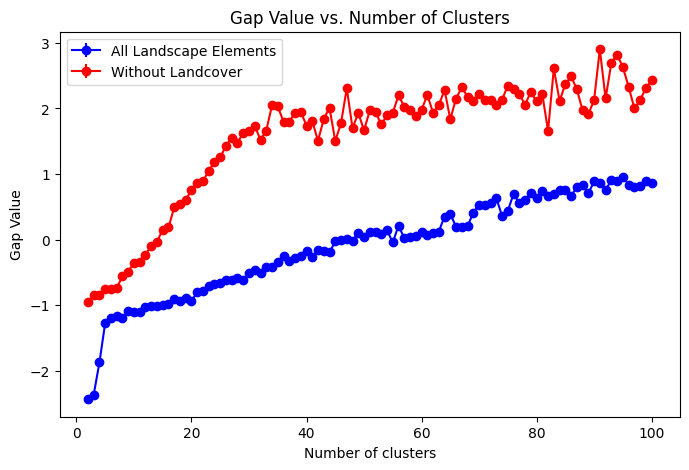

In [10]:
# GAP STATISTICS - Assumed number of clusters = 100

# Set up DASK client again
cluster = LocalCluster()
client = Client(cluster)

# Function to compute gap statistics using DASK
def compute_gap_statistics(data, max_k, sample_size=94127, B=10): #10% of total number of pixels
    def compute_dispersion(data, k):
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        clusters = kmeans.predict(data)
        cluster_centers = kmeans.cluster_centers_
        dispersion = sum(np.linalg.norm(data - cluster_centers[clusters], axis=1)) / data.shape[0]
        return dispersion
    
    def compute_reference_dispersion(data, k):
        dispersions = []
        for _ in range(B):
            reference_data = np.random.uniform(size=data.shape)
            dispersion = compute_dispersion(reference_data, k)
            dispersions.append(dispersion)
        return np.mean(dispersions), np.std(dispersions)
    
    K = range(2, max_k + 1)
    
    # Sample the data
    if len(data) > sample_size:
        data_sample = data.sample(n=sample_size, random_state=42)
    else:
        data_sample = data
    
    # Convert to DASK DataFrame
    ddf_sample = dd.from_pandas(data_sample, npartitions=4)
    
    gap_values = []
    std_devs = []
    
    for k in K:
        dispersion = compute_dispersion(ddf_sample.compute(), k)
        ref_dispersion, std_dev = compute_reference_dispersion(ddf_sample.compute(), k)
        gap_values.append(np.log(ref_dispersion) - np.log(dispersion))
        std_devs.append(std_dev)
    
    return gap_values, std_devs, K

# Perform gap statistic computation with all features using DASK
gap_values_all, std_devs_all, K_all = compute_gap_statistics(
    landscape_df[['Climate', 'Geology', 'Elevation', 'Landcover']], max_k=100)
print(f'Gap statistics for all features calculated using DASK.')

# Perform gap statistic computation without the landcover feature using DASK
gap_values_wt_lc, std_devs_wt_lc, K_wt_lc = compute_gap_statistics(
    landscape_df[['Climate', 'Geology', 'Elevation']], max_k=100)
print(f'Gap statistics without landcover calculated using DASK.')

# Save the gap statistics and the number of clusters to a CSV file
results_df_all = pd.DataFrame({'Number of Clusters': K_all, 'Gap Value (all features)': gap_values_all, 'Std Dev (all features)': std_devs_all})
results_df_wt_lc = pd.DataFrame({'Number of Clusters': K_wt_lc, 'Gap Value (without landcover)': gap_values_wt_lc, 'Std Dev (without landcover)': std_devs_wt_lc})
gap_df = pd.merge(results_df_all, results_df_wt_lc, on='Number of Clusters')
gap_df.to_csv('all_output/gap_statistics100_comparison.csv', index=False)

# Plot the gap statistics for both runs
plt.figure(figsize=(8, 5))
plt.errorbar(K_all, gap_values_all, yerr=std_devs_all, fmt='bo-', label='All Landscape Elements')
plt.errorbar(K_wt_lc, gap_values_wt_lc, yerr=std_devs_wt_lc, fmt='ro-', label='Without Landcover')
plt.xlabel('Number of clusters')
plt.ylabel('Gap Value')
plt.title('Gap Value vs. Number of Clusters')
plt.legend()

# Save the plot as both .svg and .png files
plt.savefig('all_output/gap_statistics100_comparison_plot.svg')
plt.savefig('all_output/gap_statistics100_comparison_plot.png')

plt.show()

# Close the DASK client and cluster
client.close()
cluster.close()


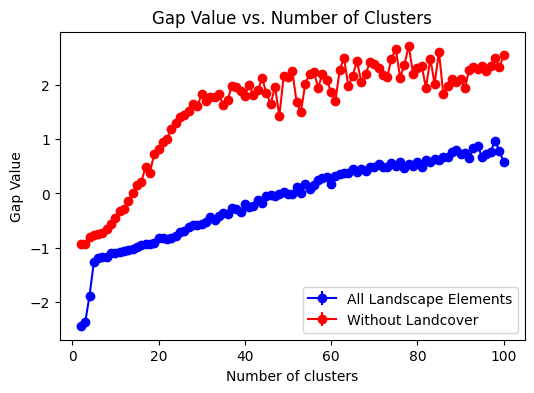

In [12]:
# Plot the gap statistics for both runs
plt.figure(figsize=(6, 4))
plt.errorbar(K_all, gap_values_all, yerr=std_devs_all, fmt='bo-', label='All Landscape Elements')
plt.errorbar(K_wt_lc, gap_values_wt_lc, yerr=std_devs_wt_lc, fmt='ro-', label='Without Landcover')
plt.xlabel('Number of clusters')
plt.ylabel('Gap Value')
plt.title('Gap Value vs. Number of Clusters')
plt.legend()

# Save the plot as both .svg and .png files
plt.savefig('all_output/gap_statistics100_1comparison_plot.svg')
plt.savefig('all_output/gap_statistics100_1comparison_plot.png')

plt.show()

**3.2 Compute Silhouette Statistics - All Landscape Element/Without Landcover**

_**100 possible number of clusters**_ are computed since the Gap Statistics shows this as the range wherein the _k_ could be obtained.

/usr/local/lib/python3.8/dist-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34941 instead
  warnings.warn(


Silhouette scores for all features calculated using DASK.
Silhouette scores without landcover calculated using DASK.


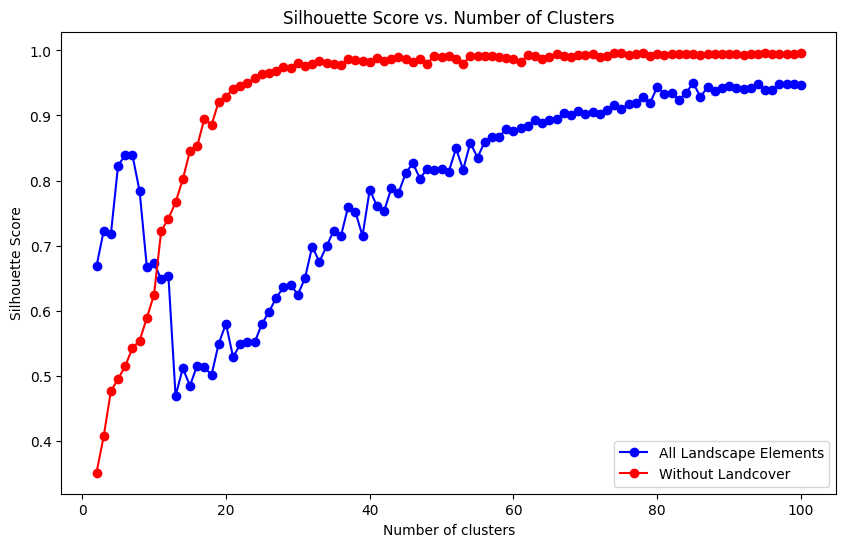

In [14]:
# SILHOUETTE STATISTICS - Assumed number of clusters = 100

# Set up DASK client and cluster
cluster = LocalCluster()
client = Client(cluster)

# Function to compute silhouette scores for a range of clusters using DASK
def compute_silhouette_scores(data, max_k, sample_size=94127):
    silhouette_scores = []
    K = range(2, max_k + 1)
    
    # Sample the data
    if len(data) > sample_size:
        data_sample = data.sample(n=sample_size, random_state=42)
    else:
        data_sample = data
    
    # Convert to DASK DataFrame
    ddf_sample = dd.from_pandas(data_sample, npartitions=4)
    
    def compute_silhouette(k):
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(ddf_sample.compute())
        return silhouette_score(ddf_sample.compute(), labels)
    
    # Parallel computation of silhouette scores
    silhouette_scores = client.map(compute_silhouette, K)
    silhouette_scores = client.gather(silhouette_scores)
    
    return silhouette_scores, K

# Perform clustering with all features using DASK
silhouette_scores_all, K_all = compute_silhouette_scores(
    landscape_df[['Climate', 'Geology', 'Elevation', 'Landcover']], max_k=100)
print(f'Silhouette scores for all features calculated using DASK.')

# Perform clustering without the landcover feature using DASK
silhouette_scores_wt_lc, K_wt_lc = compute_silhouette_scores(
    landscape_df[['Climate', 'Geology', 'Elevation']], max_k=100)
print(f'Silhouette scores without landcover calculated using DASK.')

# Save the silhouette scores and the number of clusters to a CSV file
results_df_all = pd.DataFrame({'Number of Clusters': K_all, 'Silhouette Score (all features)': silhouette_scores_all})
results_df_wt_lc = pd.DataFrame({'Number of Clusters': K_wt_lc, 'Silhouette Score (without landcover)': silhouette_scores_wt_lc})
silhouette_df = pd.merge(results_df_all, results_df_wt_lc, on='Number of Clusters')
silhouette_df.to_csv('all_output/silhouette_scores100_comparison.csv', index=False)

# Plot the silhouette scores for both runs
plt.figure(figsize=(10, 6))
plt.plot(K_all, silhouette_scores_all, 'bo-', label='All Landscape Elements')
plt.plot(K_wt_lc, silhouette_scores_wt_lc, 'ro-', label='Without Landcover')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.legend()

# Save the plot as both .svg and .png files
plt.savefig('all_output/silhouette_scores100_comparison_plot.svg')
plt.savefig('all_output/silhouette_scores100_comparison_plot.png')

plt.show()

# Close the DASK client and cluster
client.close()
cluster.close()


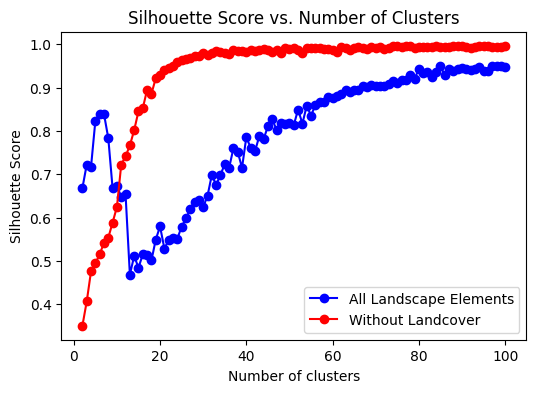

In [17]:
# Plot the silhouette scores for both runs
plt.figure(figsize=(6, 4))
plt.plot(K_all, silhouette_scores_all, 'bo-', label='All Landscape Elements')
plt.plot(K_wt_lc, silhouette_scores_wt_lc, 'ro-', label='Without Landcover')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.legend()

# Save the plot as both .svg and .png files
plt.savefig('all_output/silhouette_scores100_1comparison_plot.svg')
plt.savefig('all_output/silhouette_scores100_1comparison_plot.png')

plt.show()

**Decision:** 

*1. Making use of all landscape elements appears dramatic but it indicates that if all elements are considered, we can expect more than 100 optimal number of clusters.*

*2. We choose to make use all landscape elements, except landcover which will be used for description. Therefore, in this case, we select an optimal k of **25** as shown below. For the complete or continuation of the landscape character assessment, see **'main_cluster_analyses.ipynb'.***